# Jupyter Notebook (Python) script for recreating Fig.03

- date: 2024-06-05
- author: Tim Vogel
- group: Photonics and Ultrafast Laser Science (PULS), Ruhr-University Bochum, Germany

In [1]:
import os
import glob

import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 7
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
transmission_coeff_HDPE = 0.91 # HDPE, 2mm thickness

## Read-in digitized data from literature:

In [4]:
os.chdir("Literature_Power_Efficiency/")

In [5]:
kramer = pd.read_csv("kramer_power_vs_fluence.csv", sep=";", decimal=",", names=["fluence", "thz_power"])
kramer["fluence"] = pd.to_numeric(kramer["fluence"])
kramer["thz_power"] = 1e-3 * pd.to_numeric(kramer["thz_power"])
kramer["repetition_rate"] = 100e3
kramer["thz_energy"] = kramer["thz_power"] / kramer["repetition_rate"]
kramer2 = pd.read_csv("Kramer_THz_Result.csv", sep=";", decimal=",", names=["pump_power", "thz_power"])
kramer2["pump_power"] = pd.to_numeric(kramer2["pump_power"])
kramer2["thz_power"] = 1e-3 * pd.to_numeric(kramer2["thz_power"])

f = interpolate.interp1d(kramer2["thz_power"], kramer2["pump_power"], bounds_error=False, fill_value=(0,344))
kramer["pump_power"] = f(kramer["thz_power"])
kramer["efficiency"] = kramer["thz_power"] / kramer["pump_power"]
kramer["pump_energy"] = kramer["pump_power"] / kramer["repetition_rate"]

kroh = pd.read_csv("kroh_energy_vs_fluence.csv", sep=";", decimal=",", names=["fluence", "thz_energy"])
kroh["fluence"] = pd.to_numeric(kroh["fluence"])
kroh["thz_energy"] = pd.to_numeric(kroh["thz_energy"])
kroh["repetition_rate"] = 10
kroh["thz_power"] = kroh["thz_energy"] * kroh["repetition_rate"]
kroh2 = pd.read_csv("kroh_efficiency_vs_fluence.csv", sep=";", decimal=",", names=["fluence", "efficiency"])
kroh2["fluence"] = pd.to_numeric(kroh2["fluence"])
kroh2["efficiency"] = pd.to_numeric(kroh2["efficiency"])
g = interpolate.interp1d(kroh2["fluence"], kroh2["efficiency"], bounds_error=False, fill_value="extrapolate")
kroh["efficiency"] = g(kroh["fluence"])
kroh["pump_energy"] = kroh["thz_energy"] / kroh["efficiency"]

zhang = pd.read_csv("zhang_fluence_vs_energy.csv", sep=";", decimal=",", names=["fluence", "thz_energy"])
zhang["fluence"] = pd.to_numeric(zhang["fluence"])
zhang["thz_energy"] = pd.to_numeric(zhang["thz_energy"])
zhang["repetition_rate"] = 10
zhang["thz_power"] = zhang["thz_energy"] * zhang["repetition_rate"]
zhang2 = pd.read_csv("zhang_fluence_vs_efficiency.csv", sep=";", decimal=",", names=["fluence", "efficiency"])
zhang2["fluence"] = pd.to_numeric(zhang2["fluence"])
zhang2["efficiency"] = pd.to_numeric(zhang2["efficiency"])
h = interpolate.interp1d(zhang2["fluence"], zhang2["efficiency"], bounds_error=False, fill_value="extrapolate")
zhang["efficiency"] = h(zhang["fluence"])
zhang["pump_energy"] = zhang["thz_energy"] / zhang["efficiency"]

wu = pd.read_csv("Wu_energy_vs_energy.csv", sep=";", decimal=",", names=["pump_energy", "thz_energy"])
wu["pump_energy"] = pd.to_numeric(wu["pump_energy"])
wu["thz_energy"] = pd.to_numeric(wu["thz_energy"])
wu["thz_power"] = wu["thz_energy"]
wu2 = pd.read_csv("wu_efficiency_vs_energy.csv", sep=";", decimal=",", names=["pump_energy", "efficiency"])
k = interpolate.interp1d(wu2["pump_energy"], wu2["efficiency"], bounds_error=False, fill_value="NaN")
wu["efficiency"] = k(wu["pump_energy"])

## Read-in our result at 100 kHz, 10 measurements

In [6]:
os.chdir("../Our_Result_100kHz/")

In [7]:
file_names = glob.glob("*.h5")
oxide_dfs = []
for file_name in file_names:
    df = pd.read_hdf(file_name)
    df = df.loc[:,["pump_power", "thz_power_W", "repetition_rate"]]
    df["measurement"] = int(file_name.split("_")[-1].split(".")[0])
    oxide_dfs.append(df)
oxide_dfs = pd.concat(oxide_dfs, axis=0)
oxide_dfs.set_index(["pump_power", "measurement"], inplace=True)
oxide_dfs.sort_index(inplace=True)

df_beam = pd.read_excel("BeamDiameterAtCrystalPosition.xlsx", skiprows=3, decimal =",")

get_diameter = interpolate.interp1d(df_beam["pump_power_W"], 1e-6 * df_beam["mean_beam_diameter_um"], bounds_error=False, fill_value="extrapolate")
oxide_dfs["thz_power_corrected"] = (oxide_dfs["thz_power_W"] / transmission_coeff_HDPE) / transmission_coeff_HDPE
oxide_dfs["thz_energy"] = oxide_dfs["thz_power_corrected"] / oxide_dfs["repetition_rate"]
oxide_dfs["pump_energy"] = oxide_dfs.index.get_level_values(0) / oxide_dfs["repetition_rate"]
oxide_dfs["fluence"] = oxide_dfs["pump_energy"] / (0.5 * np.pi * (get_diameter(oxide_dfs.index.get_level_values(0)) / 2) ** 2)
oxide_dfs["avg_intensity"] = oxide_dfs.index.get_level_values(0) / (0.5 * np.pi * (get_diameter(oxide_dfs.index.get_level_values(0)) / 2) ** 2)

oxide_100kHz = oxide_dfs.copy(deep=True)

## Read-in our result at 40 kHz, 10 measurements

In [8]:
os.chdir("../Our_Result_40kHz/")

In [9]:
file_names = glob.glob("*.h5")
oxide_dfs = []
for file_name in file_names:
    df = pd.read_hdf(file_name)
    df = df.loc[:,["pump_power", "thz_power_W", "repetition_rate"]]
    df["measurement"] = int(file_name.split("_")[-1].split(".")[0])
    oxide_dfs.append(df)
oxide_dfs = pd.concat(oxide_dfs, axis=0)
oxide_dfs.set_index(["pump_power", "measurement"], inplace=True)
oxide_dfs.sort_index(inplace=True)
beam_diameter = 11.2e-3 * 0.67 # beam diameter on grating, on crystal smaller due to 300 mm and 200 mm imaging lenses
oxide_dfs["thz_power_corrected"] = oxide_dfs["thz_power_W"] / (transmission_coeff_HDPE ** 4)
oxide_dfs["thz_energy"] = oxide_dfs["thz_power_corrected"] / oxide_dfs["repetition_rate"]
oxide_dfs["pump_energy"] = oxide_dfs.index.get_level_values(0) / oxide_dfs["repetition_rate"]
oxide_dfs["fluence"] = oxide_dfs["pump_energy"] / (0.5 * np.pi * (beam_diameter / 2) ** 2)
oxide_dfs["avg_intensity"] = oxide_dfs.index.get_level_values(0) / (0.5 * np.pi * (beam_diameter / 2) ** 2)
oxide_pump = np.unique(oxide_dfs.index.get_level_values(0)).ravel()
oxide_mean = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_std = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['std']).to_numpy().ravel()
oxide_energy = np.unique(oxide_dfs["pump_energy"]).ravel()
oxide_fluence = np.unique(oxide_dfs["fluence"]).ravel()
oxide_thz_energy_mean = oxide_dfs["thz_energy"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_thz_energy_std = oxide_dfs["thz_energy"].groupby(level=0).agg(['std']).to_numpy().ravel()

## Create mean and standard deviations from measurment datasets:

In [16]:
oxide_energy_100kHz = np.unique(oxide_100kHz["pump_energy"]).ravel()
oxide_fluence_100kHz = np.unique(oxide_100kHz["fluence"]).ravel()
oxide_mean_100kHz = oxide_100kHz["thz_power_corrected"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_std_100kHz = oxide_100kHz["thz_power_corrected"].groupby(level=0).agg(['std']).to_numpy().ravel()

oxide_energy = np.unique(oxide_dfs["pump_energy"]).ravel()
oxide_fluence = np.unique(oxide_dfs["fluence"]).ravel()
oxide_mean = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_std = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['std']).to_numpy().ravel()

# Create Fig.03:

In [19]:
os.chdir("..")

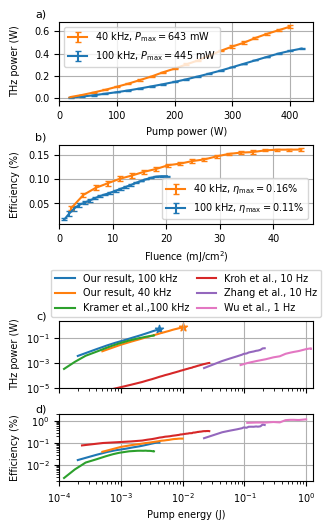

In [20]:
my_capsize=2

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8.6/2.54, 13/2.54))

ax = axs[0]
oxide_pump_100kHz = np.unique(oxide_100kHz.index.get_level_values(0)).ravel()
oxide_fluence_100kHz = oxide_100kHz["fluence"].groupby(level=0).agg(['mean'])
oxide_mean_100kHz = oxide_100kHz["thz_power_corrected"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_std_100kHz = oxide_100kHz["thz_power_corrected"].groupby(level=0).agg(['std']).to_numpy().ravel()

oxide_pump = np.unique(oxide_dfs.index.get_level_values(0)).ravel()
oxide_fluence = oxide_dfs["fluence"].groupby(level=0).agg(['mean'])
oxide_mean = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['mean']).to_numpy().ravel()
oxide_std = oxide_dfs["thz_power_corrected"].groupby(level=0).agg(['std']).to_numpy().ravel()

ax.errorbar(oxide_pump_100kHz, oxide_mean_100kHz, yerr=oxide_std_100kHz, capsize=my_capsize, label=r"100 kHz, $P_{\mathrm{max}}=$"+ EngFormatter('W',places=0)(np.max(oxide_mean_100kHz)))
ax.errorbar(oxide_pump, oxide_mean, yerr=oxide_std, capsize=my_capsize, label=r"40 kHz, $P_{\mathrm{max}}=$"+ EngFormatter('W',places=0)(np.max(oxide_mean)))
ax.grid(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.set_xlabel("Pump power (W)")
ax.set_ylabel("THz power (W)")

ax=axs[1]
labeltext = r"100 kHz, $\eta_{\mathrm{max}} = $"+f"{1e2 * np.max(oxide_mean_100kHz / oxide_pump_100kHz):.2f}%"
ax.errorbar(0.1 * oxide_fluence_100kHz, 1e2 * oxide_mean_100kHz / oxide_pump_100kHz, yerr=1e2 * oxide_std_100kHz / oxide_pump_100kHz, capsize=my_capsize, label=labeltext)
labeltext = r"40 kHz, $\eta_{\mathrm{max}} = $"+f"{1e2 * np.max(oxide_mean / oxide_pump):.2f}%"
ax.errorbar(0.1 * oxide_fluence, 1e2 * oxide_mean / oxide_pump, yerr=1e2 * oxide_std / oxide_pump, capsize=my_capsize, label=labeltext)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
ax.grid(True)
ax.set_xlabel(r"Fluence ($\mathrm{mJ}/\mathrm{cm}^2$)")
ax.set_ylabel(r"Efficiency (%)")

ax=axs[2]

ax.plot(oxide_energy_100kHz, oxide_mean_100kHz, label='Our result, 100 kHz', color="tab:blue")
ax.plot(oxide_energy, oxide_mean, label='Our result, 40 kHz', color="tab:orange") # yerr=oxide_std
ax.plot(kramer["pump_energy"], kramer["thz_power"], label="Kramer et al.,100 kHz", color="tab:green")
ax.plot(kroh["pump_energy"], kroh["thz_power"], label="Kroh et al., 10 Hz", color="tab:red")
ax.plot(zhang["pump_energy"], zhang["thz_power"], label="Zhang et al., 10 Hz", color="tab:purple")
ax.plot(wu["pump_energy"], wu["thz_power"], label="Wu et al., 1 Hz", color="tab:pink")

ax.scatter(oxide_energy_100kHz[-1], oxide_mean_100kHz[-1], c="tab:blue", marker="*")
ax.scatter(oxide_energy[-1], oxide_mean[-1], c="tab:orange", marker="*")
ax.grid(True)
ax.yaxis.set_major_formatter(EngFormatter("W"))
ax.set_ylabel("THz power (W)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=9)
ax.xaxis.set_ticklabels([])
ax.legend(loc="upper left", fancybox=True)

ax=axs[3]

eta1_100kHz = oxide_100kHz["thz_energy"].groupby(level=0).agg(['mean']).to_numpy().ravel() / oxide_energy_100kHz
eta1 = oxide_dfs["thz_energy"].groupby(level=0).agg(['mean']).to_numpy().ravel() / oxide_energy

ax.plot(oxide_energy_100kHz, 100*eta1_100kHz, label='Our result, 100 kHz', color="tab:blue")
ax.plot(oxide_energy, 100*eta1, label='Our result, 40 kHz', color="tab:orange") # yerr=oxide_thz_energy_std / oxide_energy
ax.plot(kramer["pump_energy"], 100*kramer["efficiency"], label="Kramer et al.,100 kHz", color="tab:green")
ax.plot(kroh["pump_energy"], 100*kroh["efficiency"], label="Kroh et al., 10 Hz", color="tab:red")
ax.plot(zhang["pump_energy"], 100*zhang["efficiency"], label="Zhang et al., 10 Hz", color="tab:purple")
ax.plot(wu["pump_energy"], 100*wu["efficiency"], label="Wu et al., 1 Hz", color="tab:pink")
ax.grid()

ax.set_xlabel(r"Pump energy (J)")
ax.set_ylabel("Efficiency (%)")
ax.set_xscale('log')
ax.set_yscale('log')

axs[0].set_position([0.18, 0.82, 0.75, 0.155])
axs[1].set_position([0.18, 0.58, 0.75, 0.155])
axs[2].set_position([0.18, 0.26, 0.75, 0.13])
axs[3].set_position([0.18, 0.078, 0.75, 0.13])

axs[1].set_xlim(left=0)
axs[2].set_ylim([1e-5,2])
axs[2].set_xlim([1e-4,1.3])
axs[3].set_xlim([1e-4,1.3])
axs[3].set_ylim(top=2)
axs[2].legend(loc='upper center', columnspacing=0.8, bbox_to_anchor=(0.5, 1.85), ncol=2)
fig.align_ylabels(axs)
for i, label in enumerate(('a)', 'b)', 'c)', 'd)')):
    axs[i].text(-0.05, 1.15, label, transform=axs[i].transAxes,
      fontsize=8, va='top', ha='right')
plt.savefig("Fig.03_THzPowerEfficiencyPumpPowerStateOfTheArt.png", dpi=600, facecolor="white")